In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

In [2]:
from experiments.prepare_dataset import load_amb_sin_data, prepare_df, get_data_multisin

In [60]:
df = get_data_multisin("../amb_other/chev_rand_f[xy]_5*")
#df = get_data_multisin("../amb_other/clip_rand_[fx,fy]_5*")

../amb_other/chev_rand_fx_5to69Hz_flat_0RPM.txt


../experiments/prepare_dataset.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["t"] = df["datetime"].apply(lambda x: (x - start_datetime).delta * 1e-9)


../amb_other/chev_rand_fy_5to69Hz_flat_0RPM.txt


In [90]:
frequencies = list(range(5, 70, 4))

def build_x_for_frequency_index(*args, index):

    vectors_to_concat = []
    for v in args:
        vectors_to_concat.append(v[:, index].reshape((-1, 1)))
    return np.concatenate(vectors_to_concat, axis=1)
    

def fit_sin(X, t, frequencies):
    ones_matrix = np.ones(shape=(X.shape[0], len(frequencies)))
    frequencies = np.array(frequencies).reshape((1, -1))
    freq_ts = ones_matrix * 2 * np.pi * frequencies * np.array(t).reshape((-1, 1))
    S = np.concatenate([np.sin(freq_ts), np.cos(freq_ts)], axis=1)
    
    
    amplitudes = np.linalg.lstsq(S, X, rcond=None)[0] #np.linalg.inv(S.transpose() @ S) @ S.transpose() @ np.array(X)
    
    
    #V = ( S * amplitudes ).reshape((-1, 2, len(frequencies))).sum(axis=1)
    return S, amplitudes.reshape((1,-1))

def calc_basis_matrix(S, amplitudes, index=None):
    num_frequencies = S.shape[1]//2
    V = ( S * amplitudes.reshape((1, -1)) ).reshape((-1, 2, num_frequencies))
    if index:
        return V[:, index:index+1]
    
    return V.sum(axis=1)

def first_derivative_basis(frequencies, t, num_observations=0):
    frequencies = np.array(frequencies).reshape((1, -1))
    ones_matrix = np.ones(shape=(num_observations, len(frequencies)))
    
    freq_ts = ones_matrix * 2 * np.pi * frequencies * np.array(t).reshape((-1, 1))
    S = np.concatenate([np.cos(freq_ts)*2 * np.pi * np.array(frequencies) , 
                       -np.sin(freq_ts)*2 * np.pi * np.array(frequencies)], axis=1)
    return S

def second_derivative_basis(frequencies, t, num_observations=0):
    frequencies = np.array(frequencies).reshape((1, -1))
    ones_matrix = np.ones(shape=(num_observations, len(frequencies)))
    
    freq_ts = ones_matrix * 2 * np.pi * frequencies * np.array(t).reshape((-1, 1))
    S = np.concatenate([-np.sin(freq_ts) * (2 * np.pi * np.array(frequencies))**2 , 
                       -np.cos(freq_ts) * (2 * np.pi * np.array(frequencies))**2], axis=1)
    
    return S

def build_model_one_axis(sel_df, frequencies, index):
    
    X =sel_df["x"].values.reshape((-1, 1))
    Y =sel_df["y"].values.reshape((-1, 1))
    Fx =sel_df["fx"].values.reshape((-1, 1))
    Fy =sel_df["fy"].values.reshape((-1, 1))
    F = sel_df[["fx", "fy"]].values.reshape((-1, 2))
    Q = sel_df[["x", "y"]].values.reshape((-1, 1))
    t = sel_df["t"].values.reshape((-1, 1))
    
    
    S, amplitudes_x = fit_sin(X, t, frequencies)
    _, amplitudes_y = fit_sin(Y, t, frequencies)
    _, amplitudes_fx = fit_sin(Fx, t, frequencies)
    _, amplitudes_fy = fit_sin(Fy, t, frequencies)
    _, amplitudes_f = fit_sin(F, t, frequencies)
    S_f, amplitudes_f = fit_sin(F, t, frequencies)
    S_dot = first_derivative_basis(frequencies, t, num_observations=X.shape[0])
    S_dot2 = second_derivative_basis(frequencies, t, num_observations=X.shape[0])
    
    X_project = calc_basis_matrix(S, amplitudes_x)
    Y_project = calc_basis_matrix(S, amplitudes_y)
    X_dot_project = calc_basis_matrix(S_dot,amplitudes_x)
    Y_dot_project = calc_basis_matrix(S_dot, amplitudes_y)
    X_dot2_project = calc_basis_matrix(S_dot2, amplitudes_x)
    Y_dot2_project = calc_basis_matrix(S_dot2, amplitudes_y)
    Fx_project = calc_basis_matrix(S, amplitudes_fx)
    Fy_project = calc_basis_matrix(S, amplitudes_fy)



    X_input = build_x_for_frequency_index(X_project, Y_project, X_dot_project, Y_dot_project, index=index)
    X_dot2_input = build_x_for_frequency_index(X_dot2_project, Y_dot2_project, index=index)
    #F_output = build_x_for_frequency_index(F, index=index)  
    F_output = build_x_for_frequency_index(Fx_project, Fy_project, index=index)


    Y_output = F_output - X_dot2_input @ np.array([[1, 0],[0, 1]])


    return X_input, Y_output


In [91]:
params_history = []


for index in range(len(frequencies)):
    X_x, y_x = build_model_one_axis(df[df.axis == "x"], frequencies, index = index)
    X_y, y_y = build_model_one_axis(df[df.axis == "y"], frequencies, index = index)

    X = np.concatenate([X_x, X_y], axis=0)
    y = np.concatenate([y_x, y_y], axis=0)

    params, res, _, _ = np.linalg.lstsq(X, y)
    print(params)
    print("Res:")
    print(res)
    params_history.append(params)
    
params_history = np.array(params_history)

<ipython-input-91-ab3b4feb3388>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, res, _, _ = np.linalg.lstsq(X, y)


[[ 5.01567519e+02  8.24413874e+02]
 [ 2.79873543e+03 -4.58653051e+03]
 [ 4.14593462e+00 -1.17121180e+00]
 [-2.56867990e+00  3.14783377e+01]]
Res:
[1.24206261e-29 2.04830006e-28]
[[ 1.24966033e+03  5.92555862e+02]
 [ 3.11465709e+03 -3.92860921e+03]
 [ 1.26607961e+01 -1.15258249e-01]
 [-7.80675352e+00  3.10510976e+01]]
Res:
[2.34273618e-29 1.10406950e-28]
[[ 1.30084377e+03  3.75131509e+02]
 [ 2.83314514e+03 -3.25060220e+03]
 [ 7.34115618e+00  1.08278483e+00]
 [-7.35176836e+00  3.17362715e+01]]
Res:
[2.50137714e-29 5.44379556e-29]
[[ 3.29660798e+03  1.91539478e+03]
 [ 4.73649962e+03 -2.80949372e+03]
 [ 4.63708094e+01  8.80539177e+00]
 [-2.19023141e+00  3.71921810e+01]]
Res:
[5.62660253e-28 1.10951811e-28]
[[ 6.42467594e+03 -8.49960721e+02]
 [ 1.13473965e+03  2.24744008e+03]
 [ 1.14207193e+01 -1.83809863e+00]
 [-7.36920225e+00  4.38491276e+01]]
Res:
[2.54094057e-28 1.12221323e-28]
[[ 4831.1281462  -3731.55294106]
 [  268.89890148   401.12586474]
 [   17.43102211    14.37578779]
 [    8.184

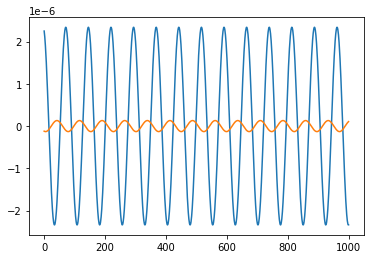

In [92]:
plt.plot(X[:1000, 0])
plt.plot(X[:1000, 1])

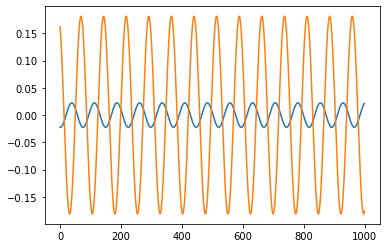

In [93]:
plt.plot(y[:1000, 1])
plt.plot(y[:1000, 0])

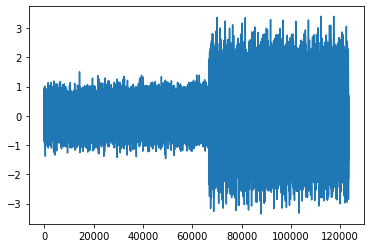

In [94]:
plt.plot(df.fy)

In [95]:
params_history.shape

(17, 4, 2)

In [96]:
axs

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

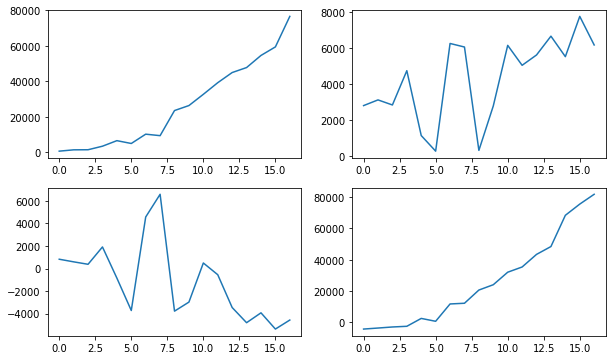

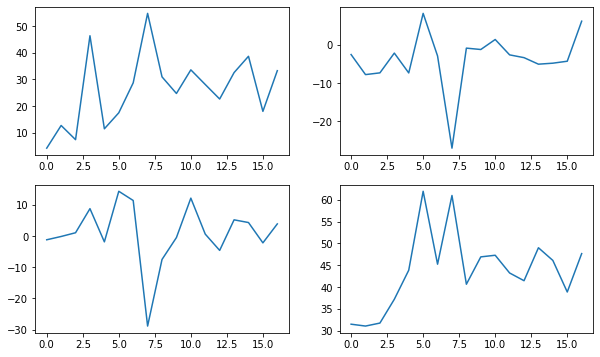

In [106]:
K = params_history[:, :2].transpose((0,2, 1))
C = params_history[:, 2:].transpose((0,2, 1))

fig, axs = plt.subplots(2, 2, figsize=(10,6))
for i in range(2):
    for j in range(2):
        axs[i,j].plot(K[:, i, j])
        
fig, axs = plt.subplots(2, 2, figsize=(10,6))
for i in range(2):
    for j in range(2):
        axs[i,j].plot(C[:, i, j])
    

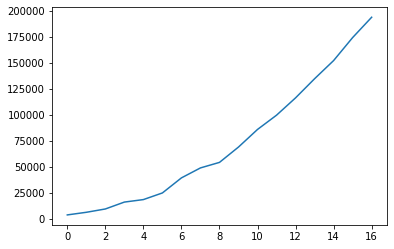

In [75]:
plt.plot(params_history[:, 1, 1])

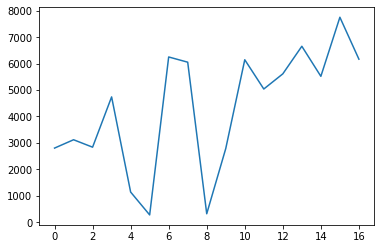

In [68]:
plt.plot(params_history[:, 1, 0])

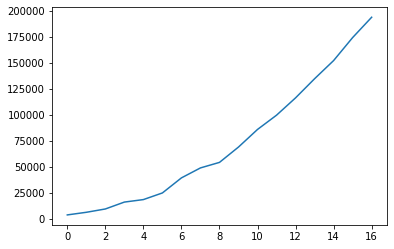

In [69]:
plt.plot(params_history[:, 1, 1])

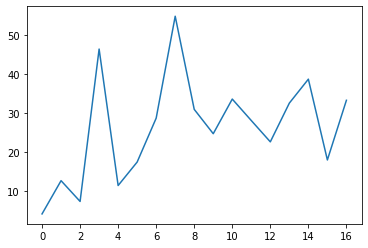

In [70]:
plt.plot(params_history[:, 2, 0])

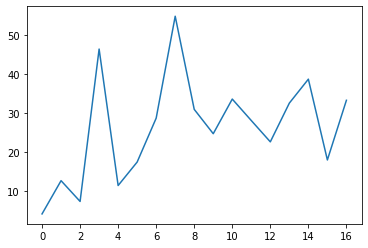

In [71]:
plt.plot(params_history[:, 2, 1])

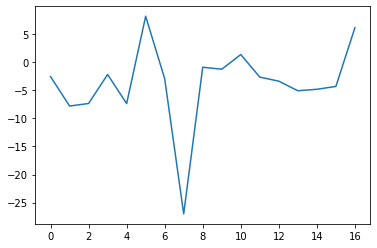

In [72]:
plt.plot(params_history[:, 3, 0])

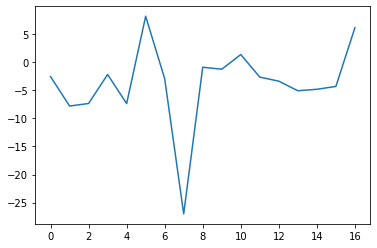

In [73]:
plt.plot(params_history[:, 3, 1])